# Linear Regression Modeling

### Import Data and Libraries and Apply Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import shap

In [1]:
def generate_datasets(pth):
    df = pd.read_parquet(pth)
    df["year"] = df["DATE_TIME"].dt.year
    df["month"] = df["DATE_TIME"].dt.month
    df["LATITUDE"] = df["LATITUDE"].astype("float")
    df["LONGITUDE"] = df["LONGITUDE"].astype("float")

    categorical_columns = ['LAND_USE', 'TERRAIN']
    for feature in categorical_columns:
        encoder = OneHotEncoder()
        encoded_data = encoder.fit_transform(df[[feature]])
        df[encoder.categories_[0]] = encoded_data.toarray()

    drop_columns = ['OZONE', "year", "DATE_TIME", "SITE_ID", "QA_CODE", "WINDSPEED", "SIGMA_THETA"] + categorical_columns
    df_train = df[df['year'].isin([2013, 2014, 2015, 2016, 2017, 2018])]
    X_train, y_train = df_train.drop(columns=drop_columns, axis=1), df_train['OZONE']

    columns = X_train.columns

    numerical_features = ['TEMPERATURE',
                        'RELATIVE_HUMIDITY',
                        'SOLAR_RADIATION',
                        'PRECIPITATION',
                        'WIND_DIRECTION',
                        'FLOW_RATE',
                        'WINDSPEED_SCALAR',
                        'SHELTER_TEMPERATURE',
                        'NO',
                        'NOY',
                        'NOYDIF',
                        'SO2_GA',
                        'LATITUDE',
                        'LONGITUDE',
                        'ELEVATION']

    ct = ColumnTransformer([
        ('Standardize Numerical Features', StandardScaler(), numerical_features)
    ], remainder='passthrough')
    X_train = ct.fit_transform(X_train)

    df_val = df[df['year'].isin([2019, 2020])]
    X_val, y_val = df_val.drop(columns=drop_columns, axis=1), df_val['OZONE']
    X_val = ct.transform(X_val)

    df_test = df[df['year'].isin([2021, 2022])]
    X_test, y_test = df_test.drop(columns=drop_columns, axis=1), df_test['OZONE']
    X_test = ct.transform(X_test)

    return columns, X_train, y_train, X_val, y_val, X_test, y_test

columns, X_train, y_train, X_val, y_val, X_test, y_test = generate_datasets("met_gas_site_cleaned.snappy.parquet")

/Users/andrealopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
columns

Index(['TEMPERATURE', 'RELATIVE_HUMIDITY', 'SOLAR_RADIATION', 'PRECIPITATION',
       'WIND_DIRECTION', 'FLOW_RATE', 'WINDSPEED_SCALAR',
       'SHELTER_TEMPERATURE', 'NO', 'NOY', 'NOYDIF', 'SO2_GA', 'LATITUDE',
       'LONGITUDE', 'ELEVATION', 'month', 'Agric', 'Forest', 'Range',
       'Complex', 'Flat', 'Rolling'],
      dtype='object')

### Baseline Linear Regression Model

In [11]:
model = LinearRegression() # default parameters, no tuning
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print("Train R^2:", r2_score(y_train, y_pred_train))
y_pred_val = model.predict(X_val)
print("Validation R^2:", r2_score(y_val, y_pred_val))
y_pred_test = model.predict(X_test)
print("Test R^2:", r2_score(y_test, y_pred_test))

Train R^2: 0.6130299482655969
Validation R^2: 0.5808890317709722
Test R^2: 0.5955484776210591


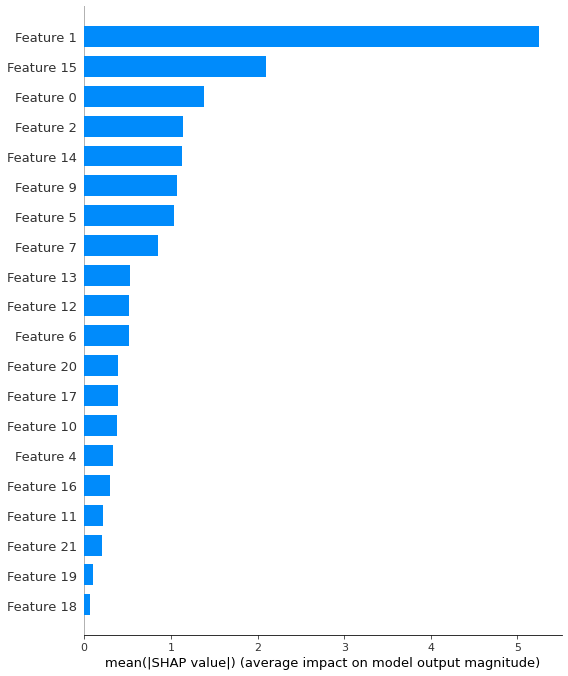

In [21]:
# Use SHAP to get most important features

explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [24]:
print(columns[0], columns[15], columns[1])
# The most important features were temperature, month, and relative humidity.

TEMPERATURE month RELATIVE_HUMIDITY


## Lasso Regression Model

In [7]:
%%time

# hyperparameter tuning
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [10000, 100000]
}

model_lasso = Lasso()
grid_search = GridSearchCV(model_lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best parameters:")
print(grid_search.best_params_)

model_lasso_best = Lasso(alpha=grid_search.best_params_['alpha'],
                        max_iter=grid_search.best_params_['max_iter'])

model_lasso_best.fit(X_train, y_train)

y_pred_val = model_lasso_best.predict(X_val)
print("Validation R^2:", r2_score(y_val, y_pred_val))
y_pred_test = model_lasso_best.predict(X_test)
print("Test R^2:", r2_score(y_test, y_pred_test))

Best parameters:
{'alpha': 0.01, 'max_iter': 10000}
Validation R^2: 0.5811537522819731
Test R^2: 0.5958156111265835
CPU times: user 2min 43s, sys: 22.1 s, total: 3min 5s
Wall time: 46.1 s


## Ridge Regression Model

In [8]:
%%time

# hyperparameter tuning 
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [10000, 100000]
}

model_ridge = Ridge()
grid_search = GridSearchCV(model_ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best parameters:")
print(grid_search.best_params_)

model_ridge_best = Ridge(alpha=grid_search.best_params_['alpha'],
                        max_iter=grid_search.best_params_['max_iter'])

model_ridge_best.fit(X_train, y_train)

y_pred_val = model_ridge_best.predict(X_val)
print("Validation R^2:", r2_score(y_val, y_pred_val))
y_pred_test = model_ridge_best.predict(X_test)
print("Test R^2:", r2_score(y_test, y_pred_test))

Best parameters:
{'alpha': 10, 'max_iter': 10000}
Validation R^2: 0.5808912212692833
Test R^2: 0.595549640792371
CPU times: user 6.09 s, sys: 2.07 s, total: 8.16 s
Wall time: 2.33 s


## Elastic Net Regression Model

In [10]:
%%time

# hyperparameter tuning
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [10000, 100000],
    'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]
}

model_elastic_net = ElasticNet()
grid_search = GridSearchCV(model_elastic_net, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best parameters:")
print(grid_search.best_params_)

model_elastic_net_best = ElasticNet(alpha=grid_search.best_params_['alpha'],
                        max_iter=grid_search.best_params_['max_iter'],
                        l1_ratio=grid_search.best_params_['l1_ratio'])

model_elastic_net_best.fit(X_train, y_train)

y_pred_val = model_elastic_net_best.predict(X_val)
print("Validation R2:", r2_score(y_val, y_pred_val))
y_pred_test = model_elastic_net_best.predict(X_test)
print("Test R2:", r2_score(y_test, y_pred_test))

Best parameters:
{'alpha': 0.01, 'l1_ratio': 0.75, 'max_iter': 10000}
Validation R2: 0.581163750437486
Test R2: 0.5957603821001163
CPU times: user 14min 29s, sys: 1min 48s, total: 16min 18s
Wall time: 4min 2s


In [12]:
y_pred_train = model_elastic_net_best.predict(X_train)
print("Train R^2:", r2_score(y_train, y_pred_train))

Train R^2: 0.6130135488976084


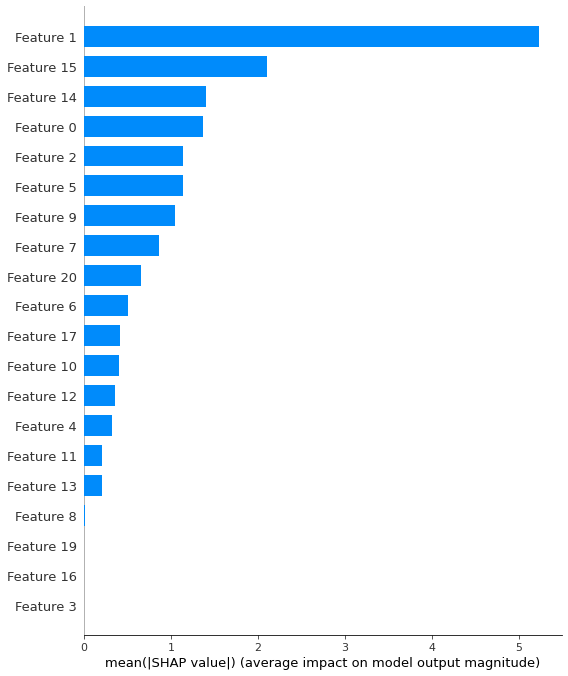

In [22]:
# Use SHAP to get most important features
explainer = shap.Explainer(model_elastic_net_best, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [26]:
print(columns[1], columns[15], columns[14])
# The most important features were relative humidity, month, and elevation.

RELATIVE_HUMIDITY month ELEVATION
